# Calculating Eigenvalues  with Quantum Phase Estimation algorithm

In this demo we show how Quantum Phase Estimation algorithm can be used to calculate eigenvalues of a matrix.



## 1 Overview of Quantum Phase Estimation algorithm

Given a unitary operator $U$ with eigenvalues $e ^{2 \pi  i \phi}$ and eigenvectors $\left| u \right>$, QPE allows to find phase $\phi$. 

In order to do so, QPE requires 2 registers: 1 storing the input vector $\left| \psi \right>$, and 1 ancilla register that stores the $\phi$, as can be seen on the circuit schematic below.

The whole procedure is done in 3 steps:
1. The ancilla register is put in superposition by applying the H gates.
2. A series of U controlled rotations are applied on the $\left| \psi \right>$ register, which leave each kth ancilla qubit in state $\left| 0 \right> + e^{2 \pi i (2^{t-1})}\left| 1 \right> $
3. Inverse Fourier transform is applied on the ancilla register which leaves it in state $\left| \phi \right>$ that can be measured


<img src="images/Quantum_phase_estimation.png"  width="500 px" align="center">



## 2 Algorithm set up

This section explains step-by--step how the Quantum phase estimation algorithm is implemented in QISKit. 



### 2.1 Initiate
First we need to import the packages and initiate the program.

In [2]:
import sys
sys.path.append("..")

from qpe_hhl.qpe import QPE
from demo_functions import *
import numpy as np
from matrix_gen import gen_matrix
import matplotlib.pyplot as plt
qpe = QPE()

### 2.2 Define the matrix
Now, we are ready to define the matrix, for example:

In [3]:
#matrix = gen_matrix(2, eigrange=[-4, 4], sparsity=0.6)  #random matrix
#or:
matrix = np.matrix([[-1.5, -2], [-2,1.5]])                     #your own

n = len(matrix)                                         #n is the size of the system

### 2.3 Define the input state vector

In this next step we choose the input vector. If the input vector happens to be an eigenvector the system gets into eigenstate, and as a consequence the outcome of the QPE is only a single eigenvalue (that corresponds to this eigenvector). 

In case it is desired to find all the eigenvalues, the system needs to be in a superposition of all the eigenstates - therefore the input vector shall be a combination of all the eigenvectors.

In [4]:
invec = [1,1]

### 2.4 Define the algorithm parameters
Finally we choose the backend and the algorithm parameters:

In [5]:
backend = "local_qasm_simulator"

k = 3
nege = True

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae': k,                   #Increase #of ancilla qubits - increase precision of eigenvalues
            'num_time_slices': 3,               #Increase # of time slices - improves accuracy of Hamiltonian simulation
            'expansion_mode': 'suzuki',          #Approximation method for matrix exponentiation
            'expansion_order': 2,                #Number of terms in aforementioned approximation of matrix exponentiation 
            'hermitian_matrix': True,
            'negative_evals': nege,              #Flag: are negative eigenvalues allowed ?
            'backend' : backend,
            #'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec
    }
}

## 3 Results

In the next step the algorithm is executed and the final results are retrieved. In this case the results are in form of a histogram.

The results obtained with the quantum computing aproach are compared with the classical.  

### 3.1 Executing on a Local Simulator

/home/gawel/.local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


COMPLETED
{'backend': 'local_qasm_simulator_py', 'id': 'b297a969-8d98-4bae-ad94-24de43effba4', 'job_id': '921a3675-3b06-4ca6-a7fd-87b86a58f234', 'result': [{'name': 'circuit1', 'seed': 64720517, 'shots': 1024, 'data': {'counts': {'011': 874, '010': 89, '101': 21, '111': 20, '100': 6, '001': 8, '110': 4, '000': 2}, 'snapshots': {}}, 'status': 'DONE', 'success': True, 'time_taken': 17.25259804725647}], 'status': 'COMPLETED', 'success': True, 'time_taken': 17.252675771713257}


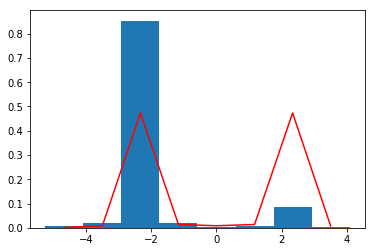

In [6]:
qpe.init_params(params, matrix)
qc = qpe._compute_eigenvalue()
res = qpe._ret

plot_res_and_theory(res, matrix, k, nege)

In [7]:
w, v = np.linalg.eig(matrix)
print('Eigenvalues found with simulator:', Efr(res))
print('Eigenvalues found classically:', w.real.round(2))

Eigenvalues found with simulator: [-2.  2.]
Eigenvalues found classically: [-2.5  2.5]


### 3.2 Executing on a Quantum Computer

Now lets solve the same problem on an actual Quantum computer, and see how the results compare.

In [8]:
initiate_q_backend()

Qconfig loaded from ../../Qconfig.py.
['ibmq_qasm_simulator', 'ibmqx2', 'ibmqx4', 'ibmqx5', 'local_qasm_simulator', 'local_statevector_simulator', 'local_unitary_simulator']


In [9]:
k = 3
nege = True
params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae': k,
            'num_time_slices': 3,
            'expansion_mode': 'suzuki',
            'expansion_order': 2,
            'hermitian_matrix': True,
            'negative_evals': nege,
            'backend' : 'ibmqx5',
            #'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec#[1/2**0.5,1/2**0.5]
    }
}
# ibm_x5: max settings: for n = 2 k=3, suzuki, expansion order =2, -> max 3 time slices

COMPLETED
{'id': '5b890406f6d959003ee8498b', 'status': 'COMPLETED', 'used_credits': 3, 'result': [{'data': {'time': 23.32465696334839, 'counts': {'000': 164, '100': 175, '001': 168, '101': 156, '010': 71, '110': 86, '011': 115, '111': 89}, 'date': '2018-08-31T09:32:38.654Z'}, 'name': 'circuit6', 'compiled_circuit_qasm': '\ninclude "qelib1.inc";\nqreg q[16];\ncreg c[3];\nu2(0,3.14159265358979) q[15];\nu3(1.57079632679490,0,0) q[2];\nu2(0,3.14159265358979) q[1];\nu2(0,3.14159265358979) q[0];\nbarrier q[2];\nu2(0.0930115116892839,3.14159265358979) q[2];\ncx q[15],q[0];\nu2(0,3.14159265358979) q[0];\nu2(0,3.14159265358979) q[15];\ncx q[15],q[0];\nu2(0,3.14159265358979) q[0];\nu2(0,3.14159265358979) q[15];\ncx q[15],q[0];\ncx q[15],q[2];\nu1(-0.0930115116892839) q[2];\ncx q[15],q[2];\nu2(0.0697586337669629,3.14159265358979) q[2];\ncx q[15],q[2];\nu1(-0.0697586337669629) q[2];\ncx q[15],q[2];\nu1(0.0697586337669629) q[2];\ncx q[15],q[2];\nu1(-0.0697586337669629) q[2];\ncx q[15],q[2];\nu2(0.0

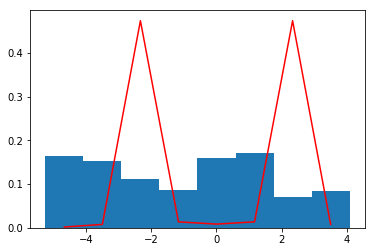

In [10]:
qpe = QPE()
qpe.init_params(params, matrix)
qc = qpe._compute_eigenvalue()
res_q = qpe._ret

plot_res_and_theory(res_q, matrix, k, nege)

## 3.3 Comparison of the results
You can see that the results from the actual Quantum computer are much more noisy - the peaks are not that sharp.

Eigenvalues found with real device: [ 1. -5.]
Eigenvalues found with simulator: [-2.  2.]
Eigenvalues found classically: [-2.5  2.5]


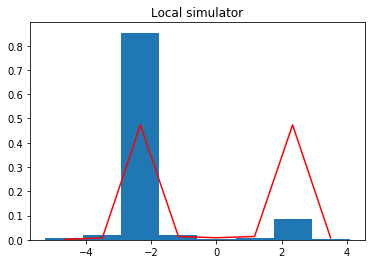

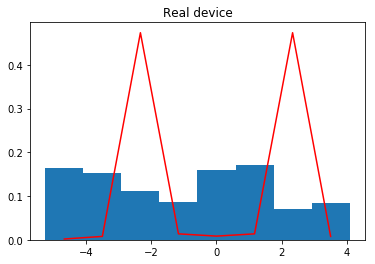

In [11]:
#from demo_functions import Efr

print('Eigenvalues found with real device:', Efr(res_q))
print('Eigenvalues found with simulator:', Efr(res))
print('Eigenvalues found classically:', w.round(3))



plt.title('Local simulator')
plot_res_and_theory(res, matrix, k, nege)
plt.title('Real device')
plot_res_and_theory(res_q, matrix, k, nege)